In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from statsmodels.tsa.stattools import adfuller, acf
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from pmdarima.arima.utils import nsdiffs

import time
import pickle

In [2]:
path = '../Dataset/Power Networks/Power-Networks-LCL-June2015(withAcornGps).csv_Pieces/'
filename = '2013_agg_dates.csv'
df = pd.read_csv(path+filename)

In [3]:
fig_path = '../Figures/'

# Functions

In [4]:
def split_sets(train_window, test_window, df, column): # get train and test set without labels
    train_df = pd.DataFrame()
    for value in train_window:
        temp = df.loc[df[column] == value]
        train_df = pd.concat([train_df, temp], axis = 0)

    test_df = pd.DataFrame()
    for value in test_window:
        temp = df.loc[df[column] == value]
        test_df = pd.concat([test_df, temp], axis = 0)

    return train_df, test_df

In [5]:
## IGNORE ##
# def train_sarima(train_set, d): 
#     sarima = pm.auto_arima(train_set, start_p=0, max_p=3, start_q=0, max_q=3, d= d,
#                              test='adf', m=24*7, start_P=0, seasonal=True,
#                              D=1, trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)
#     return sarima

In [6]:
def make_datetime(year, day, month, hour):# get values return datetime
    dtstr = '{}-{}-{}'.format(year, int(month), int(day))
    adate = datetime.strptime(dtstr, '%Y-%m-%d')
    newdate = adate.replace(hour=int(hour), minute=0)
    return newdate

In [7]:
# MAPE
def get_mape(actuals, predictions): 
    return np.mean(abs((actuals-predictions)/actuals))*100

In [8]:
# RMSE
def get_rmse(actuals, predictions):
    return np.sqrt(np.mean(actuals-predictions)**2)

In [9]:
# MAE
def get_mae(actuals, predictions):
    return np.mean(abs(actuals - predictions))

In [10]:
# R Squared
def get_r_squared(actuals, predictions):
    ac_bar = np.mean(actuals)
    SS_res = sum((actuals - predictions)**2)
    SS_tot = sum((actuals - ac_bar)**2)
    r_sq = 1 - (SS_res/SS_tot)
    return r_sq

In [11]:
# Find max index
def create_max_demand(df):
    df['MaxDemand'] = df.groupby(['Month', 'Day'])['kw'].transform('max')
    df['MaxDemandIndex'] = df['MaxDemand'] == df['kw']
    return df

In [12]:
# Convert prediction array to df similar to test
def create_pred_df(prediction, test):
    pred_series = pd.Series(prediction)
    pred_series.index = test.index
    pred_df = pd.DataFrame({'kw': pred_series, 'Hour':test['Hour'], 'Day': test['Day'], 'Month': test['Month']})
    pred_df = create_max_demand(pred_df)
    return pred_df

# Aggregations

In [13]:
sample = df.groupby(['Month', 'WeekNumber', 'Day', 'Hour'])['kw'].sum().reset_index()

In [14]:
sample['DateTime'] = sample.apply(lambda row: make_datetime(2013, row['Day'], row['Month'], row['Hour']), axis = 1)
sample = sample.set_index('DateTime')

In [15]:
sample = create_max_demand(sample)

In [16]:
sample.head()

,Month,WeekNumber,Day,Hour,kw,MaxDemand,MaxDemandIndex
DateTime,,,,,,,
2013-01-01 00:00:00,1,1,1,0,1307.121999,1865.019999,False
2013-01-01 01:00:00,1,1,1,1,1069.776001,1865.019999,False
2013-01-01 02:00:00,1,1,1,2,841.458000,1865.019999,False
2013-01-01 03:00:00,1,1,1,3,710.730001,1865.019999,False
2013-01-01 04:00:00,1,1,1,4,650.642000,1865.019999,False


# Dry Run

In [17]:
train, test = split_sets([1, 2, 3], [4], sample, 'WeekNumber')
t = time.time()
sarima24 = pm.auto_arima(train.kw, start_p=0, max_p=3, start_q=0, max_q=3, d= 0, test='adf', m=24, start_P=0, seasonal=True, D=0, trace=True,error_action='ignore', suppress_warnings=True, stepwise=True)
t - time.time()

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 24); AIC=7358.888, BIC=7371.695, Fit time=2.218 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=7843.565, BIC=7852.103, Fit time=0.033 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=5868.415, BIC=5885.492, Fit time=10.948 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=6811.909, BIC=6828.985, Fit time=3.935 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=6809.430, BIC=6822.238, Fit time=0.065 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 24); AIC=5850.849, BIC=5872.194, Fit time=53.164 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 24); AIC=5871.000, BIC=5896.614, Fit time=44.499 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 0, 24); AIC=6972.723, BIC=6989.800, Fit time=59.682 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 24); AIC=5781.642, BIC=5807.257, Fit time=85.027 seconds
Fit ARIMA: order=(2, 0,

-508.12764143943787

In [18]:
sarima24.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  528
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood               -2884.821
Date:                            Wed, 30 Oct 2019   AIC                           5781.642
Time:                                    17:37:03   BIC                           5807.257
Sample:                                         0   HQIC                          5791.670
                                            - 528                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.4784      4.747      3.892      0.000       9.174      27.783
ar.L1          1.1816      0.031     38.301      0.000       1.121       1.242
ar.L2         -0.3580      0.031    -11.490      0.000      -0.419      -0.297
ar.S.L24       0.6690      0.040     16.529      0.000       0.590       0.748
ar.S.L48       0.2465      0.040      6.210      0.000       0.169       0.324
sigma2      3009.1294    136.799     21.997      0.000    2741.008    3277.251
===================================================================================
Ljung-Box (Q):                       67.56   Jarque-Bera (JB):               125.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

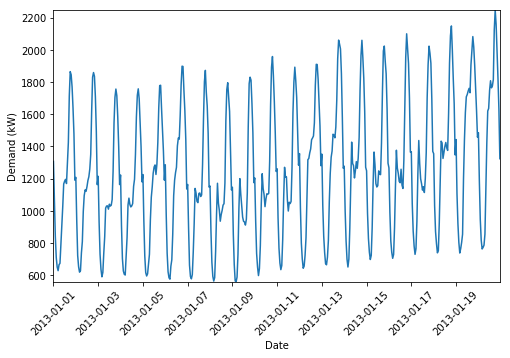

In [20]:
train_ = train.loc[train['Month'] != 12] # exclude the December
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(train_.index, train_['kw'])
plt.xlabel('Date')
plt.ylabel('Demand (kW)')
plt.xticks(rotation = 45)
# ax.axvspan(train_.index[3], train_.index[8], facecolor='green', alpha=0.2)
plt.margins(0)
plt.savefig(fig_path+'training_SARIMA.png')
plt.show()

In [21]:
# Predict Set confidence intervals for plotting
prediction, conf_int = sarima24.predict(n_periods=test.shape[0], return_conf_int=True)
test['prediction'] = prediction
test['low'] = conf_int[:,0]
test['high'] = conf_int[:,1]

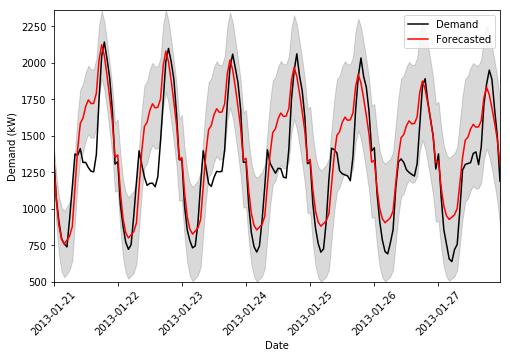

In [78]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.plot(test.index, test.kw, color = 'black') # plot actual
ax.plot(test.index, test['prediction'], color = 'red') # plot forecast
plt.fill_between(test.index,  # plot conf int
                 test['low'], 
                 test['high'], 
                 color='k', alpha=.15)
# set labels
plt.xticks(rotation = 45)
plt.margins(0)
plt.xlabel('Date')
plt.ylabel('Demand (kW)')
plt.legend(['Demand','Forecasted'])
plt.savefig(fig_path+'testing_SARIMA.png')
plt.show()

C:\Users\Thanasis\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


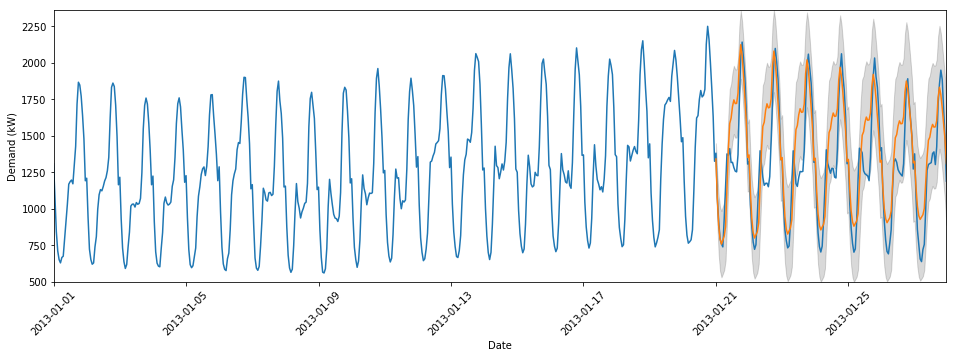

In [286]:
tt = pd.concat([train_, test])
fig, ax = plt.subplots(figsize = (16, 5))
ax.plot(tt.index, tt['kw'])
ax.plot(tt.index, tt['prediction'])
plt.fill_between(tt.index, 
                 tt['low'], 
                 tt['high'], 
                 color='k', alpha=.15)
plt.xlabel('Date')
plt.ylabel('Demand (kW)')
plt.xticks(rotation = 45)
plt.margins(0)
plt.show()

In [264]:
test.head()

,level_0,index,Month,WeekNumber,Day,Hour,kw,MaxDemand,MaxDemandIndex,prediction
DateTime,,,,,,,,,,
2013-12-23 00:00:00,8592,8592,12,52,23,0,1228.522002,1829.178,False,1339.532001
2013-12-23 01:00:00,8593,8593,12,52,23,1,947.304002,1829.178,False,1067.545173
2013-12-23 02:00:00,8594,8594,12,52,23,2,745.574000,1829.178,False,883.321388
2013-12-23 03:00:00,8595,8595,12,52,23,3,638.096000,1829.178,False,790.394841
2013-12-23 04:00:00,8596,8596,12,52,23,4,598.280000,1829.178,False,756.222941


# Testing Metrics

In [181]:
prediction = sarima24.predict(n_periods=test.shape[0])
get_mape(prediction, test.kw)

15.032079660482514

In [200]:
# obtain MAPE only for the peak of the day based on actuals
pred_series = pd.Series(prediction)
pred_series.index = test.index
get_mape(pred_series.loc[test['MaxDemandIndex']], test.kw.loc[test['MaxDemandIndex']])

6.063659885567336

In [246]:
# obtain the offset
pred_df = pd.DataFrame({'kw': pred_series, 'Hour':test['Hour'], 'Day': test['Day'], 'Month': test['Month']})
pred_df = create_max_demand(pred_df)

get_mape(test['Hour'].loc[test['MaxDemandIndex']].values, pred_df['Hour'].loc[pred_df['MaxDemandIndex']].values)

5.555555555555556

In [287]:
get_mape(test['kw'].loc[test['MaxDemandIndex']].values, pred_df['kw'].loc[pred_df['MaxDemandIndex']].values)

3.0701281504398676

# Walking Forward SARIMA

In [16]:
# Initial Parameters for train and test split
train_week = 3
test_week =1
hours_in_week = 24*7

predict_period = hours_in_week*test_week

# Create lists of list with the week index for train and test
train_list = []
test_list = []
for i in range(1, 50):
    train_list.append([j+i for j in range(0, train_week)])
    test_list.append([train_week+i])

In [17]:
p_list = []
p_value_list = []
for train_id, test_id in zip(train_list, test_list):
    train, test = split_sets(train_id, test_id, sample, 'WeekNumber')
    adf = adfuller(train.kw)
    p = 0
    if (adf[1] > 0.05):
        adf = adfuller(train.kw.diff().dropna())
        d = 1
    p_list.append(p)
    p_value_list.append(adf[1])
#     print('ADF Statistic is {} and p-value is {}'.format(result[0], result[1]))

In [18]:
# Obtaining 2 difference order with test
d_list = [] # Trend difference order
D_list = [] # Season difference order
for train_id, test_id in zip(train_list, test_list):
    train, test = split_sets(train_id, test_id, sample, 'WeekNumber')
    n_adf = ndiffs(train.kw, test='adf')
    D = nsdiffs(train.kw,
            m=24,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')
    d_list.append(n_adf)
    D_list.append(D)

In [19]:
# Get models for each training set
model_l = []
for train_id, test_id, d, D in zip(train_list, test_list, d_list, D_list):
    print(test_id)
    t_train, t_test = split_sets(train_id, test_id, sample, 'WeekNumber')
    model = pm.auto_arima(t_train.kw, start_p=0, max_p=3, start_q=0, max_q=3, d= d, test='adf', m=24, start_P=0, seasonal=True, D=D, trace=True,error_action='ignore', suppress_warnings=True, stepwise=True)
    model_l.append(model)

[4]
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 24); AIC=7358.888, BIC=7371.695, Fit time=1.117 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=7843.565, BIC=7852.103, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=5868.415, BIC=5885.492, Fit time=5.030 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=6811.909, BIC=6828.985, Fit time=1.816 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=6809.430, BIC=6822.238, Fit time=0.031 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 24); AIC=5850.849, BIC=5872.194, Fit time=26.613 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 24); AIC=5871.000, BIC=5896.614, Fit time=20.943 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 0, 24); AIC=6972.723, BIC=6989.800, Fit time=29.595 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 24); AIC=5781.642, BIC=5807.257, Fit time=41.068 seconds
Fit ARIMA: order=(2,

In [45]:
order = []
sorder = []
for model in model_l:
    order.append(model.order)
    sorder.append(model.seasonal_order)

In [ ]:
pickle_path = '../Pickles/'

In [151]:
# # save model with pickle
# with open(pickle_path+"auto_sarima_24_models.pckl", "wb") as f:
#     for model in model_l:
#          pickle.dump(model, f)

# Evaluation of model

In [155]:
# model_l = []
# with open("auto_sarima_24_models.pckl", "rb") as f:
#     while True:
#         try:
#             models.append(pickle.load(f))
#         except EOFError:
#             break

In [162]:
aic_l = []
bic_l = []
for model in model_l:
    aic_l.append(model.aic())
    bic_l.append(model.bic())

In [163]:
dict_ =  {'Train Week':train_list, 'Test Week': test_list, 'Order': order, 'Seasonal Order': sorder, 'AIC': aic_l, 'BIC': bic_l}
evaluation_table = pd.DataFrame.from_dict(dict_)

In [165]:
# writer = pd.ExcelWriter('../Tables/sarima_evaluation.xlsx')
# evaluation_table.to_excel(writer)
# writer.save()

# Metrics used
>https://web.maths.unsw.edu.au/~adelle/Garvan/Assays/GoodnessOfFit.html

In [108]:
mape_l_week = []
r_l_week = []

mape_l_ac = []
r_l_ac = []

mae_off_l = []
rmse_off_l = []

mape_l_ac_pd = []
r_l_ac_pd = []
for train_id, test_id, model in zip(train_list, test_list, model_l):
    t_train, t_test = split_sets(train_id, test_id, sample, 'WeekNumber')    
    t_pred = model.predict(n_periods=t_test.shape[0])
    t_df_pred = create_pred_df(t_pred, t_test)
    
    # Weekly MAPE
    mape = get_mape(t_test.kw, t_df_pred.kw)
    mape_l_week.append(mape)
    # Weekly R-squared
    r_sq = get_r_squared(t_test.kw, t_df_pred.kw)
    r_l_week.append(r_sq)
    
    # MAPE only for peak of actuals
    mape_peak_actual = get_mape(t_test.kw.loc[t_test['MaxDemandIndex']], t_df_pred.kw.loc[t_test['MaxDemandIndex']])
    mape_l_ac.append(mape_peak_actual)
    # R-squared only for peak of actuals
    r_sq_peak_actual = get_r_squared(t_test.kw.loc[t_test['MaxDemandIndex']], t_df_pred.kw.loc[t_test['MaxDemandIndex']])
    r_l_ac.append(r_sq_peak_actual)

    # MAPE only for peak of actuals and forecasted
    mape_peak_actual_for = get_mape(t_test['kw'].loc[t_test['MaxDemandIndex']].values, t_df_pred['kw'].loc[t_df_pred['MaxDemandIndex']].values)
    mape_l_ac_pd.append(mape_peak_actual_for)
    # R-squared for peak of actuals and forecasted
    r_sq_peak_actual_for = get_r_squared(t_test['kw'].loc[t_test['MaxDemandIndex']].values, t_df_pred['kw'].loc[t_df_pred['MaxDemandIndex']].values)
    r_l_ac_pd.append(r_sq_peak_actual_for)
    
    # Offset MAE and RMSE
    mae_off = get_mae(t_test['Hour'].loc[t_test['MaxDemandIndex']].values, t_df_pred['Hour'].loc[t_df_pred['MaxDemandIndex']].values)
    rmse_off = get_rmse(t_test['Hour'].loc[t_test['MaxDemandIndex']].values, t_df_pred['Hour'].loc[t_df_pred['MaxDemandIndex']].values)
    mae_off_l.append(mae_off)
    rmse_off_l.append(rmse_off)


In [109]:
dict_ =  {'Train Week':train_list, 'Test Week': test_list, 'Order': order, 'Seasonal Order': sorder, 'MAPE Week': mape_l_week, 'R-Squared Week': r_l_week, 'MAPE on Actual Peak': mape_l_ac, 'R-Squared on Actual Peak': r_l_ac, 'MAPE Actual vs Forecasted Peak': mape_l_ac_pd, 'R-Squared Actual vs Forecasted Peak': r_l_ac_pd, 'MAE Peak Offset': mae_off_l, 'RMSE Peak Offset': rmse_off_l}
results_table = pd.DataFrame.from_dict(dict_)

In [124]:
# writer = pd.ExcelWriter('../Tables/sarima_results.xlsx')
# results_table.to_excel(writer)
# writer.save()

In [76]:
# results_table = pd.read_excel('../Tables/sarima_results.xlsx')

In [94]:
res_t = results_table[['MAPE Week', 'R-Squared Week']].agg({'mean', 'min', 'max', 'std'}).T.rename(columns = {'mean': 'Mean', 'min': 'Minimum', 'max': 'Maximum', 'std':'Standard Deviation'})
res_t.index = ['MAPE', 'R-Squared']
res_t.loc['R-Squared'] = res_t.loc['R-Squared']*100
res_t

,Standard Deviation,Maximum,Mean,Minimum
MAPE,3.072251,22.678404,12.284403,5.991264
R-Squared,8.728611,91.823078,75.213630,49.854608


In [95]:
# writer = pd.ExcelWriter('../Tables/weekly_results.xlsx')
# res_t.to_excel(writer)
# writer.save()

In [100]:
peak_res = results_table[['MAE Peak Offset', 'MAPE Actual vs Forecasted Peak']].agg({'mean', 'min', 'max', 'std'}).T.rename(columns = {'mean': 'Mean', 'min': 'Minimum', 'max': 'Maximum', 'std':'Standard Deviation'})
peak_res

,Standard Deviation,Maximum,Mean,Minimum
MAE Peak Offset,0.480044,2.142857,0.469388,0.000000
MAPE Actual vs Forecasted Peak,3.789318,18.228686,8.899947,2.149371


In [101]:
# writer = pd.ExcelWriter('../Tables/peak_results.xlsx')
# peak_res.to_excel(writer)
# writer.save()

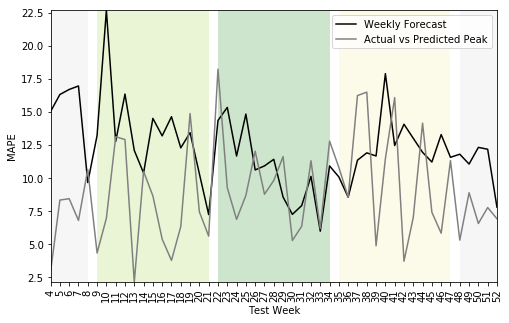

In [77]:
fig, ax = plt.subplots(figsize = (8, 5))
x =np.arange(4, 53)
ax.plot(x, results_table['MAPE Week'], color = 'black', alpha = 1)
# ax.plot(x, results_table['MAPE on Actual Peak'], color = 'red', alpha = 1)
ax.plot(x, results_table['MAPE Actual vs Forecasted Peak'], color = 'gray', alpha = 1)
ax.set_xticks(np.arange(4, 53))
plt.xticks(rotation = 90)
plt.margins(0)
plt.xlabel('Test Week')
plt.ylabel('MAPE')

# Background colors
ax.axvspan(4, 8, facecolor='lightgrey', alpha=0.2)
ax.axvspan(9, 21, facecolor='yellowgreen', alpha=0.2)
ax.axvspan(22, 34, facecolor='green', alpha=0.2)
ax.axvspan(35, 47, facecolor='khaki', alpha=0.2)
ax.axvspan(48, 52, facecolor='lightgrey', alpha=0.2)
# plt.legend(['Weekly Forecast','Actual Peak', 'Actual vs Predicted Peak'])
plt.legend(['Weekly Forecast', 'Actual vs Predicted Peak'])
plt.savefig(fig_path+'mape_SARIMA.png')
plt.show()

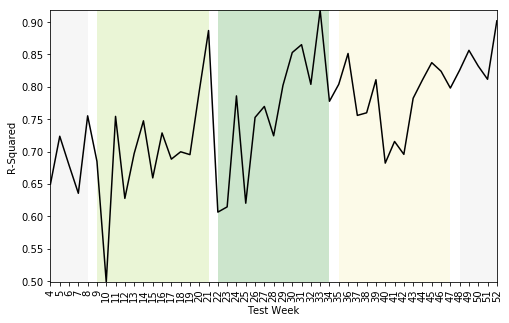

In [96]:
fig, ax = plt.subplots(figsize = (8, 5))
x =np.arange(4, 53)
ax.plot(x, results_table['R-Squared Week'], color = 'black', alpha = 1)
# ax.plot(x, results_table['R-Squared on Actual Peak'], color = 'red', alpha = 0.5)
# ax.plot(x, results_table['R-Squared Actual vs Forecasted Peak'], color = 'green', alpha = 0.5)
ax.set_xticks(np.arange(4, 53))
plt.xticks(rotation = 90)
plt.margins(0)
plt.xlabel('Test Week')
plt.ylabel('R-Squared')

# Background colors
ax.axvspan(4, 8, facecolor='lightgrey', alpha=0.2)
ax.axvspan(9, 21, facecolor='yellowgreen', alpha=0.2)
ax.axvspan(22, 34, facecolor='green', alpha=0.2)
ax.axvspan(35, 47, facecolor='khaki', alpha=0.2)
ax.axvspan(48, 52, facecolor='lightgrey', alpha=0.2)
# plt.legend(['Weekly Forecast','Actual Peak', 'Actual vs Predicted Peak'])
plt.savefig(fig_path+'r_squared_SARIMA.png')
plt.show()

In [83]:
results_table[[col for col in results_table.columns if 'R-Squared' in col]]

R-Squared Week                         0.752136
R-Squared on Actual Peak              -9.061275
R-Squared Actual vs Forecasted Peak   -7.904640
dtype: float64

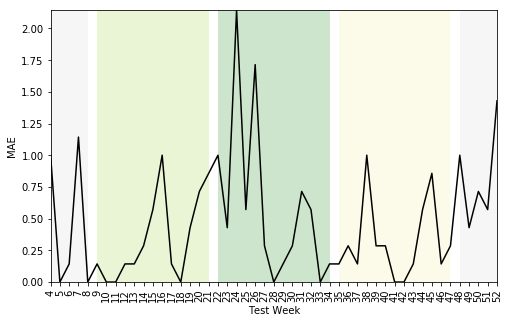

In [67]:
fig, ax = plt.subplots(figsize = (8, 5))
x =np.arange(4, 53)
ax.plot(x, results_table['MAE Peak Offset'], color = 'black', alpha = 1)
# ax.plot(x, results_table['RMSE Peak Offset'], color = 'red', alpha = 0.5)
ax.set_xticks(np.arange(4, 53))
plt.xticks(rotation = 90)
plt.margins(0)
plt.xlabel('Test Week')

# Background colors
ax.axvspan(4, 8, facecolor='lightgrey', alpha=0.2)
ax.axvspan(9, 21, facecolor='yellowgreen', alpha=0.2)
ax.axvspan(22, 34, facecolor='green', alpha=0.2)
ax.axvspan(35, 47, facecolor='khaki', alpha=0.2)
ax.axvspan(48, 52, facecolor='lightgrey', alpha=0.2)
plt.ylabel('MAE')
# plt.legend(['MAE Hour Offset','RMSE Hour Offset'])
plt.savefig(fig_path+'mae_offset_SARIMA.png')
plt.show()

In [126]:
results_table.groupby(['Order', 'Seasonal Order']).size()

Order      Seasonal Order
(1, 0, 0)  (1, 0, 1, 24)      1
           (2, 0, 0, 24)      1
(1, 0, 1)  (1, 0, 1, 24)      1
           (2, 0, 0, 24)      4
(1, 0, 2)  (1, 0, 0, 24)      1
           (1, 0, 1, 24)      1
           (2, 0, 0, 24)      1
(2, 0, 0)  (1, 0, 0, 24)     14
           (1, 0, 1, 24)      5
           (2, 0, 0, 24)     16
           (2, 0, 2, 24)      1
(2, 0, 3)  (2, 0, 0, 24)      1
(3, 0, 1)  (2, 0, 0, 24)      1
(3, 0, 3)  (1, 0, 2, 24)      1
dtype: int64

# Evaluation and Validation tables

In [26]:
val_df = pd.read_excel('../Tables/sarima_evaluation.xlsx')
val_df.drop('Unnamed: 0', axis =1, inplace = True)

In [40]:
val_sum  = val_df[['AIC', 'BIC']].agg({'mean', 'min', 'max', 'std'})
# val_sum.index = ['Minimum', 'Maximum', 'Mean', 'Standard Dev']
val_sum.T

,std,max,mean,min
AIC,205.215858,5781.642278,5255.399091,4886.543842
BIC,205.531589,5807.256856,5280.567895,4911.879300


In [29]:
# writer = pd.ExcelWriter('../Tables/val_summary.xlsx')
# val_sum.to_excel(writer)
# writer.save()

In [42]:
val_sum_T = val_sum.T.rename(columns = {'mean':'Mean', 'max':'Maximum', 'min':'Minimum', 'std': 'Standard Deviation' })
val_sum_T

,Standard Deviation,Maximum,Mean,Minimum
AIC,205.215858,5781.642278,5255.399091,4886.543842
BIC,205.531589,5807.256856,5280.567895,4911.879300


In [44]:
# writer = pd.ExcelWriter('../Tables/val_summary_T.xlsx')
# val_sum_T.to_excel(writer)
# writer.save()

In [71]:
# Convert training lists to a readable format (eg [1, 2, 3] to 1-3)
tr_l = [val.strip('[]').split(',') for val in val_df['Train Week']] # strip and split
tr_xlabel = [val[0]+'-'+val[2].strip(' ')for val in tr_l] # obtain edge values and format

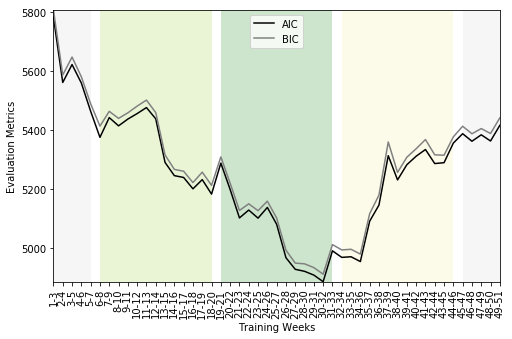

In [72]:
fig, ax = plt.subplots(figsize = (8, 5))

x =np.arange(4, 53)
ax.plot(x, val_df.AIC, color = 'black', alpha = 1)
ax.plot(x, val_df.BIC, color = 'gray', alpha = 1)
ax.set_xticks(np.arange(4, 53))

plt.xticks(rotation = 90)
plt.margins(0)
plt.xlabel('Training Weeks')
plt.ylabel('Evaluation Metrics')
plt.legend(['AIC','BIC'])

# Background colors
ax.axvspan(4, 8, facecolor='lightgrey', alpha=0.2)
ax.axvspan(9, 21, facecolor='yellowgreen', alpha=0.2)
ax.axvspan(22, 34, facecolor='green', alpha=0.2)
ax.axvspan(35, 47, facecolor='khaki', alpha=0.2)
ax.axvspan(48, 52, facecolor='lightgrey', alpha=0.2)
ax.set_xticklabels(tr_xlabel)
plt.savefig(fig_path+'AIC_BIC_SARIMA.png')
plt.show()

In [37]:
val_df

,Train Week,Test Week,Order,Seasonal Order,AIC,BIC
0,"[1, 2, 3]",[4],"(2, 0, 0)","(2, 0, 0, 24)",5781.642278,5807.256856
1,"[2, 3, 4]",[5],"(2, 0, 0)","(2, 0, 0, 24)",5561.337641,5586.673098
2,"[3, 4, 5]",[6],"(1, 0, 1)","(2, 0, 0, 24)",5622.107817,5647.443274
3,"[4, 5, 6]",[7],"(2, 0, 0)","(1, 0, 0, 24)",5559.322174,5580.435055
4,"[5, 6, 7]",[8],"(2, 0, 0)","(1, 0, 1, 24)",5463.804113,5489.139571
5,"[6, 7, 8]",[9],"(2, 0, 3)","(2, 0, 0, 24)",5375.462755,5413.465941
6,"[7, 8, 9]",[10],"(2, 0, 0)","(1, 0, 0, 24)",5442.374962,5463.487844
7,"[8, 9, 10]",[11],"(2, 0, 0)","(2, 0, 0, 24)",5414.397352,5439.732810
8,"[9, 10, 11]",[12],"(2, 0, 0)","(1, 0, 0, 24)",5437.381117,5458.493998
9,"[10, 11, 12]",[13],"(2, 0, 0)","(1, 0, 1, 24)",5455.970883,5481.306341
